I am looking for patterns suggesting that some proteins' expression levels correlate with genotype (control or Down Syndrom model) and/or learning.

In [113]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [165]:
data = pd.read_csv('Data_Cortex_Nuclear_Means_Clean.csv')
data1 = data.set_index(['Genotype','Behavior','Treatment'])
data1 = data1.drop(['class','Mouse'],axis = 1)

In [166]:
# Set up y tick labels to mark divisions between groups
yticks = [0,10,19,29,38,47,54,63]
yticklabels = ['Control Learning Treated',
               'Control Learning Untreated',
               'Control NoLearning Treated',
               'Control NoLearning Untreated',
               'Downs Learning Treated',
               'Downs Learning Untreated',
               'Downs NoLearning Treated',
               'Downs NoLearning Untreated']

First, I am looking at a heatmap of the normalized expression data without clustering and with the individual mice arranged by group.  Many genes appear to show similar expression patterns to each other.

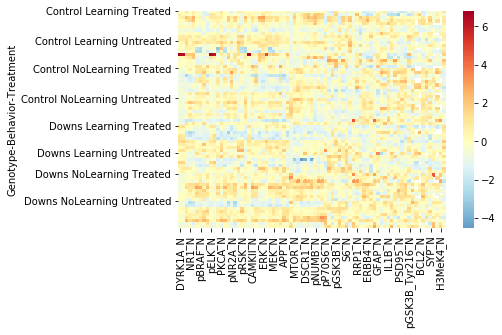

In [168]:
# Heatmap of normalized data
# Data is normalized by z-scores ((x - mean)/std) so that all proteins are on approximately the same visual scale
# regardless of absolute expression levels
ax = sns.heatmap((data1-data1.mean())/data1.std(),yticklabels=yticklabels,center=0,cmap='RdYlBu_r')
ax.set_yticks(yticks)
ax

Just by eye, it looks like the CaNA_N expression is related to whether the mouse experienced a learning paradigm.

In [180]:
data1

Index(['DYRK1A_N', 'ITSN1_N', 'BDNF_N', 'NR1_N', 'NR2A_N', 'pAKT_N', 'pBRAF_N',
       'pCAMKII_N', 'pCREB_N', 'pELK_N', 'pERK_N', 'pJNK_N', 'PKCA_N',
       'pMEK_N', 'pNR1_N', 'pNR2A_N', 'pNR2B_N', 'pPKCAB_N', 'pRSK_N', 'AKT_N',
       'BRAF_N', 'CAMKII_N', 'CREB_N', 'ELK_N', 'ERK_N', 'GSK3B_N', 'JNK_N',
       'MEK_N', 'TRKA_N', 'RSK_N', 'APP_N', 'Bcatenin_N', 'SOD1_N', 'MTOR_N',
       'P38_N', 'pMTOR_N', 'DSCR1_N', 'AMPKA_N', 'NR2B_N', 'pNUMB_N',
       'RAPTOR_N', 'TIAM1_N', 'pP70S6_N', 'NUMB_N', 'P70S6_N', 'pGSK3B_N',
       'pPKCG_N', 'CDK5_N', 'S6_N', 'ADARB1_N', 'AcetylH3K9_N', 'RRP1_N',
       'BAX_N', 'ARC_N', 'ERBB4_N', 'nNOS_N', 'Tau_N', 'GFAP_N', 'GluR3_N',
       'GluR4_N', 'IL1B_N', 'P3525_N', 'pCASP9_N', 'PSD95_N', 'SNCA_N',
       'Ubiquitin_N', 'pGSK3B_Tyr216_N', 'SHH_N', 'BAD_N', 'BCL2_N', 'pS6_N',
       'pCFOS_N', 'SYP_N', 'H3AcK18_N', 'EGR1_N', 'H3MeK4_N', 'CaNA_N'],
      dtype='object')

When looking globally at expression data, does the data cluster by group?  (Note that proteins with missing data had to be dropped from this analysis for now.)

In [178]:
# Apparently I can't use clustermap with missing values and I can't colorcode groups with a multiindex
# First, ignore proteins with missing values
data2 = data.loc[:,data.isnull().sum()==0]
# Then remove all non-protein variables, saving class for color-coding
groups = data2.pop('class')
data2 = data2.drop(['Genotype','Behavior','Treatment','Mouse'],axis=1)
# Create color code for row clustering
colors = ['#3182bd','#9ecae1', #Control genotype, Learning = blues
          'k','#636363', #Control genoteyp, No learning = greys
          '#de2d26','#fc9272', #Down Syndrome, Learning = reds
          '#7a0177','#df65b0'] #Down Syndrome, No Learning = purples
row_colors = groups.map(dict(zip(groups.unique(), colors)))

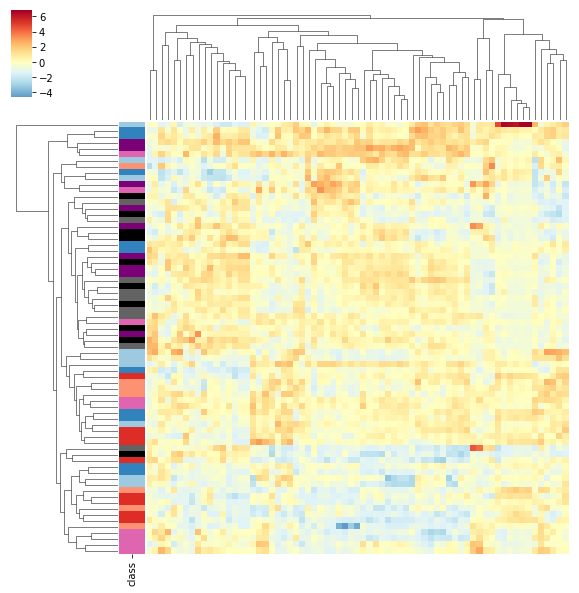

In [179]:
ax3=sns.clustermap(data2,center=0,cmap='RdYlBu_r',z_score=1,row_colors=row_colors,xticklabels=False,yticklabels=False)

It looks like the control genotype (grey/black, blues) and Down syndrome model (reds/pinks/purple) do show some clustering even before filtering for genes differing between groups.